In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizerFast, BertForTokenClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import torch
from transformers import BertTokenizer, BertModel
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import torch
import warnings
warnings.filterwarnings('ignore')

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
df = pd.read_csv('mtsamples.csv')
df = df.drop(columns='Unnamed: 0')
df

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
...,...,...,...,...,...
4994,Patient having severe sinusitis about two to ...,Allergy / Immunology,Chronic Sinusitis,"HISTORY:, I had the pleasure of meeting and e...",NaN
4995,This is a 14-month-old baby boy Caucasian who...,Allergy / Immunology,Kawasaki Disease - Discharge Summary,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...","allergy / immunology, mucous membranes, conjun..."
4996,A female for a complete physical and follow u...,Allergy / Immunology,Followup on Asthma,"SUBJECTIVE: , This is a 42-year-old white fema...",NaN
4997,Mother states he has been wheezing and coughing.,Allergy / Immunology,Asthma in a 5-year-old,"CHIEF COMPLAINT: , This 5-year-old male presen...",NaN


# Анализ данных

In [39]:
train_df, test_df = train_test_split(df, random_state=42, stratify=df['keywords'].isnull())

print("Размер тренировочного набора:", train_df.shape)
print("Размер тестового набора:", test_df.shape)

Размер тренировочного набора: (3749, 5)
Размер тестового набора: (1250, 5)


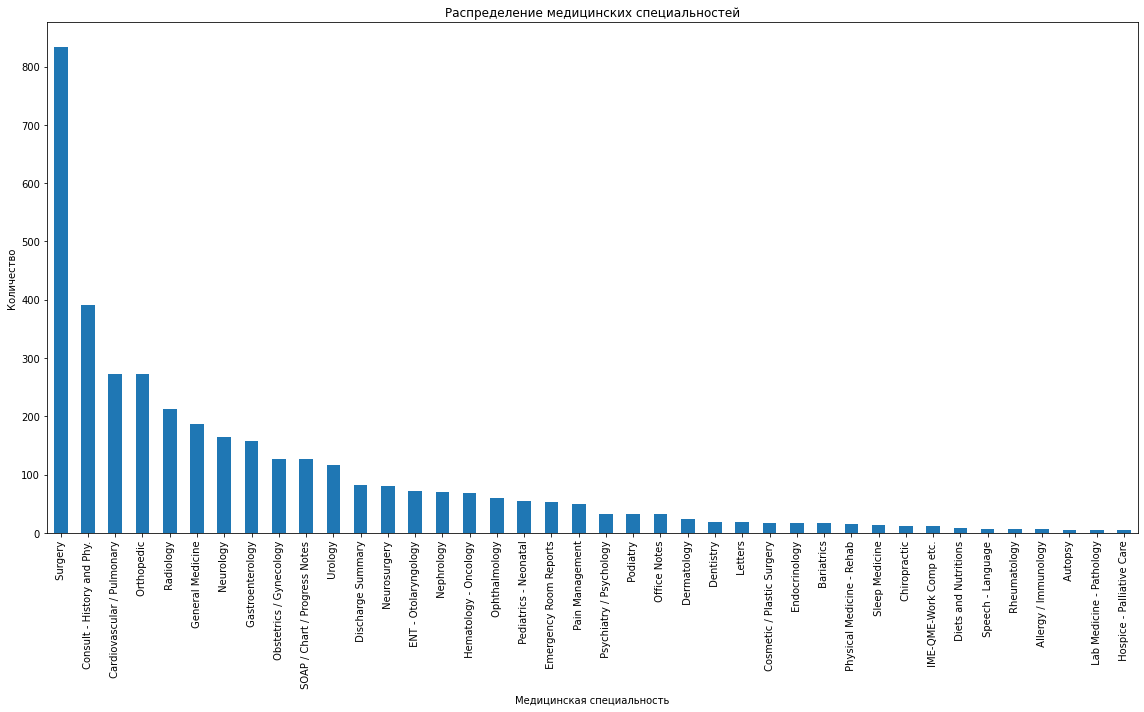

In [38]:
specialty_counts = train_df['medical_specialty'].value_counts()

plt.figure(figsize=(16,10))
specialty_counts.plot(kind='bar')
plt.title('Распределение медицинских специальностей')
plt.xlabel('Медицинская специальность')
plt.ylabel('Количество')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [40]:
len(train_df['medical_specialty'].value_counts())

40

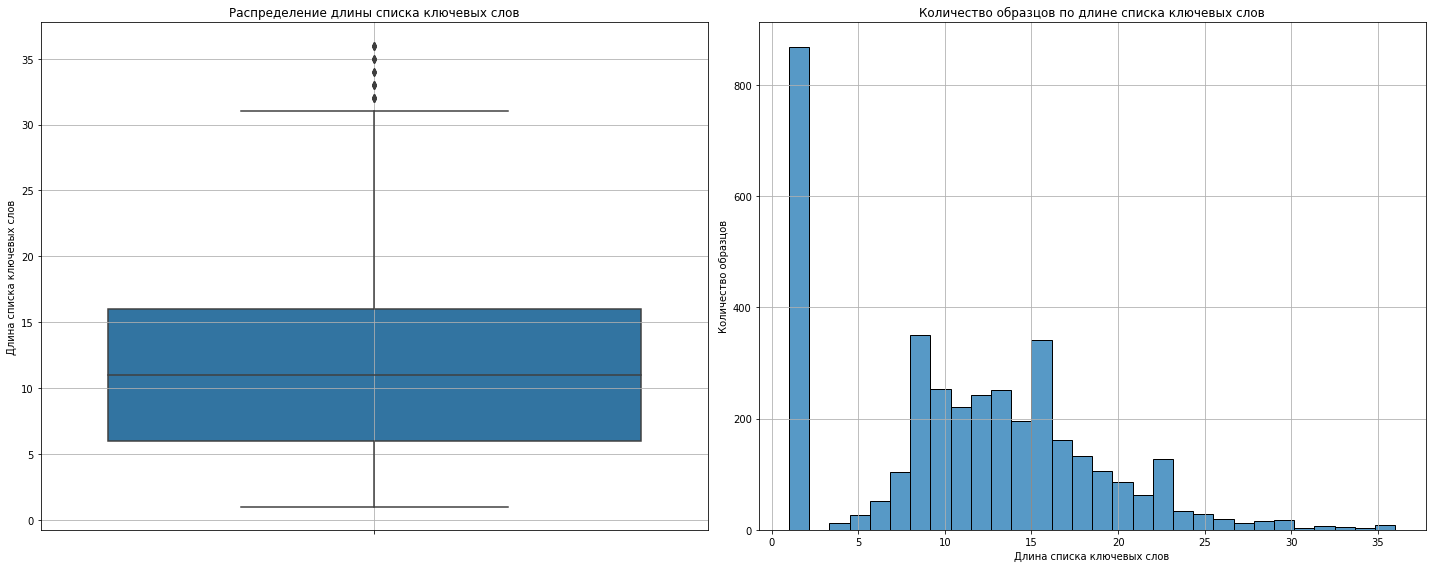

In [48]:
keyword_lengths = train_df['keywords'].apply(lambda x: len(str(x).split(',')))

plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
sns.boxplot(y=keyword_lengths, data=train_df)
plt.title('Распределение длины списка ключевых слов')
plt.ylabel('Длина списка ключевых слов')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.histplot(data=train_df, x=keyword_lengths, bins=30)
plt.title('Количество образцов по длине списка ключевых слов')
plt.xlabel('Длина списка ключевых слов')
plt.ylabel('Количество образцов')
plt.grid(True)

plt.tight_layout()
plt.show()

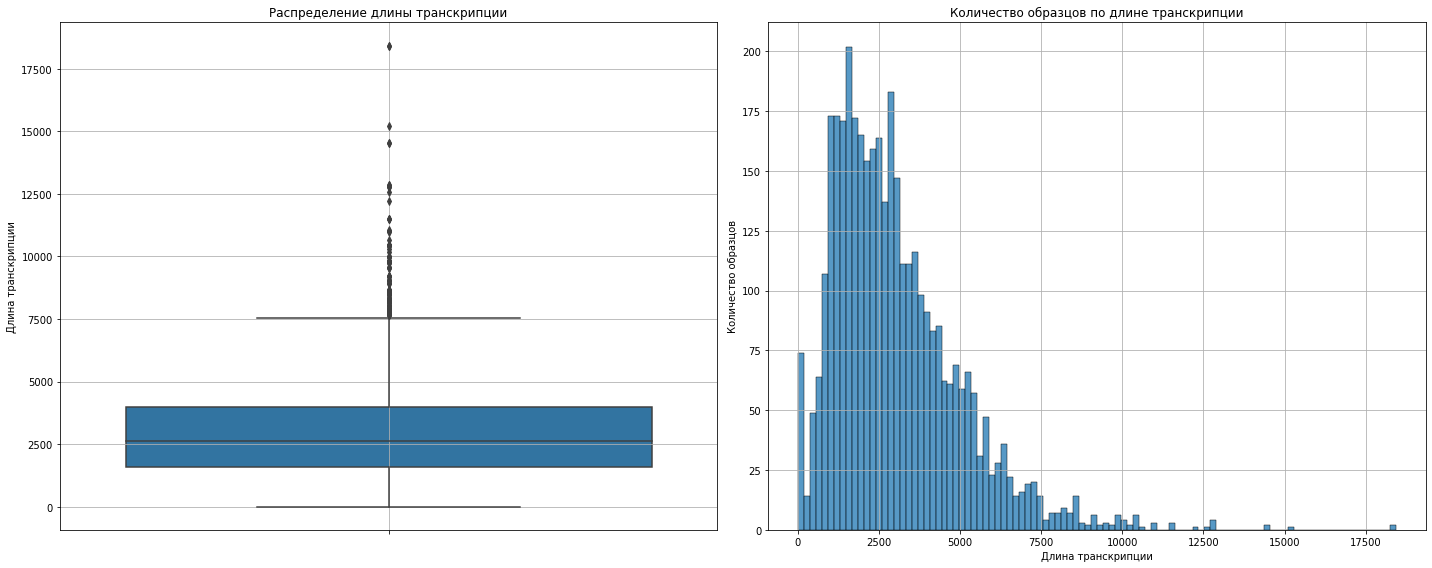

In [53]:
transcription_lengths = train_df['transcription'].apply(lambda x: len(str(x)))

plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
sns.boxplot(y=transcription_lengths, data=train_df)
plt.title('Распределение длины транскрипции')
plt.ylabel('Длина транскрипции')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.histplot(data=train_df, x=transcription_lengths, bins=100)
plt.title('Количество образцов по длине транскрипции')
plt.xlabel('Длина транскрипции')
plt.ylabel('Количество образцов')
plt.grid(True)

plt.tight_layout()
plt.show()

# BERT

## Предобработка данных

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import RobertaModel, RobertaTokenizer
from transformers import BertTokenizer
from keras.utils import pad_sequences

2024-04-21 19:03:48.513829: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
df = df.dropna(subset=['transcription'])
X = df['transcription'].tolist()
X = [str(text) for text in X if pd.notnull(text)]
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(df['medical_specialty'])
y = encoded_labels

In [5]:
from transformers import BertForTokenClassification, BertTokenizerFast

model = RobertaModel.from_pretrained('roberta-base')
tokenizer = BertTokenizerFast.from_pretrained("without_anomalies_PUBMEDBERT_tokenizer")

inputs = tokenizer(X, padding=True, truncation=True, return_tensors="pt", max_length=512)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def generate_embeddings(model, inputs, batch_size=16):
    model.eval()
    embeddings = []
    for i in tqdm(range(0, inputs['input_ids'].size(0), batch_size)):
        batch_input_ids = inputs['input_ids'][i:i+batch_size].to(device)
        batch_attention_mask = inputs['attention_mask'][i:i+batch_size].to(device)
        with torch.no_grad():
            batch_outputs = model(batch_input_ids, attention_mask=batch_attention_mask)
            batch_embeddings = batch_outputs.last_hidden_state.mean(dim=1)
            embeddings.append(batch_embeddings.cpu().numpy())
    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings

embeddings = generate_embeddings(model, inputs)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 311/311 [00:49<00:00,  6.25it/s]


In [6]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
embeddings_resampled, labels_resampled = ros.fit_resample(embeddings, y)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(embeddings_resampled, labels_resampled, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [8]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
hidden_dim = 256
num_classes = np.unique(y).shape[0]
mlp_model = SimpleClassifier(input_dim=768, hidden_dim=hidden_dim, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

batch_size = 16
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_data = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

## Обучение модели

In [10]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import f1_score

epochs = 30
loss_values_train, loss_values_val, f1_values = [], [], []

for epoch in range(epochs):
    mlp_model.train()
    total_loss = 0
    
    for batch in tqdm(train_loader, desc="Training", total=len(train_loader)):
        b_input_ids, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_labels = b_labels.to(device)

        optimizer.zero_grad()

        outputs = mlp_model(b_input_ids)

        loss = criterion(outputs, b_labels)
        total_loss += loss.item()

        loss.backward()

        optimizer.step()
    avg_train_loss = total_loss / len(train_loader)
    loss_values_train.append(avg_train_loss)


    mlp_model.eval()
    eval_loss = 0
    predictions, true_labels = [], []
    
    best_val_loss = float('inf')
    best_model_state = None
    
    for batch in tqdm(val_loader, desc="Validation", total=len(val_loader)):
        b_input_ids, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_labels = b_labels.to(device)
        
        with torch.no_grad(): 
            outputs = mlp_model(b_input_ids)
        
        loss = criterion(outputs, b_labels)
        eval_loss += loss.item()

        logits = outputs.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.append(np.argmax(logits, axis=1))
        true_labels.append(label_ids)

    eval_loss = eval_loss / len(val_loader)
    loss_values_val.append(eval_loss)
    predictions = np.concatenate(predictions)
    true_labels = np.concatenate(true_labels)
    f1 = f1_score(true_labels, predictions, average='weighted')
    f1_values.append(f1)

    print(f'Epoch {epoch + 1} | Train Loss: {avg_train_loss} | Val Loss: {eval_loss} | Val F1: {f1}')
    if eval_loss < best_val_loss:
        best_val_loss = eval_loss
        best_model_state = mlp_model.state_dict()

Validation: 100%|██████████| 544/544 [00:00<00:00, 1236.84it/s]


Epoch 1 | Train Loss: 2.409808666865323 | Val Loss: 1.6931983807726818 | Val F1: 0.48648475905580213


Validation: 100%|██████████| 544/544 [00:00<00:00, 1194.62it/s]


Epoch 2 | Train Loss: 1.4298735404314071 | Val Loss: 1.201813248479191 | Val F1: 0.6217615549315278


Validation: 100%|██████████| 544/544 [00:00<00:00, 1239.29it/s]


Epoch 3 | Train Loss: 1.1261883726270467 | Val Loss: 1.009077461765093 | Val F1: 0.6819935324378917


Validation: 100%|██████████| 544/544 [00:00<00:00, 1228.86it/s]


Epoch 4 | Train Loss: 0.9585341965122258 | Val Loss: 0.9118706990471658 | Val F1: 0.7045848515239568


Validation: 100%|██████████| 544/544 [00:00<00:00, 1211.49it/s]


Epoch 5 | Train Loss: 0.8531342735559698 | Val Loss: 0.8345028604380786 | Val F1: 0.7228352606239862


Validation: 100%|██████████| 544/544 [00:00<00:00, 1205.93it/s]


Epoch 6 | Train Loss: 0.7824050682898173 | Val Loss: 0.80974800175275 | Val F1: 0.7316286983523469


Validation: 100%|██████████| 544/544 [00:00<00:00, 1237.97it/s]


Epoch 7 | Train Loss: 0.7325231884560529 | Val Loss: 0.7755483562838944 | Val F1: 0.7379128946008069


Validation: 100%|██████████| 544/544 [00:00<00:00, 1205.79it/s]


Epoch 8 | Train Loss: 0.6953809717350512 | Val Loss: 0.7601122528533725 | Val F1: 0.7393523956775067


Validation: 100%|██████████| 544/544 [00:00<00:00, 1165.75it/s]


Epoch 9 | Train Loss: 0.6650208296281669 | Val Loss: 0.7436784074285671 | Val F1: 0.7454655372012754


Validation: 100%|██████████| 544/544 [00:00<00:00, 1206.95it/s]


Epoch 10 | Train Loss: 0.6405923563311351 | Val Loss: 0.7287649295484537 | Val F1: 0.7494171909703411


Validation: 100%|██████████| 544/544 [00:00<00:00, 1158.13it/s]


Epoch 11 | Train Loss: 0.6213757580502287 | Val Loss: 0.7219765347099918 | Val F1: 0.7466337174430533


Validation: 100%|██████████| 544/544 [00:00<00:00, 1237.89it/s]


Epoch 12 | Train Loss: 0.6022412179896206 | Val Loss: 0.7365041625658598 | Val F1: 0.7472835415512499


Validation: 100%|██████████| 544/544 [00:00<00:00, 1209.64it/s]


Epoch 13 | Train Loss: 0.5846378435837287 | Val Loss: 0.7190977867747492 | Val F1: 0.7517511098631054


Validation: 100%|██████████| 544/544 [00:00<00:00, 1102.07it/s]


Epoch 14 | Train Loss: 0.5710505437808951 | Val Loss: 0.7358315854935962 | Val F1: 0.7460880807146527


Validation: 100%|██████████| 544/544 [00:00<00:00, 1197.60it/s]


Epoch 15 | Train Loss: 0.5586408493131874 | Val Loss: 0.7362652045592446 | Val F1: 0.7457624024719638


Validation: 100%|██████████| 544/544 [00:00<00:00, 1225.09it/s]


Epoch 16 | Train Loss: 0.5481507317573928 | Val Loss: 0.752033671405276 | Val F1: 0.7417082151158845


Validation: 100%|██████████| 544/544 [00:00<00:00, 1208.50it/s]


Epoch 17 | Train Loss: 0.5362422589929409 | Val Loss: 0.7418088487842504 | Val F1: 0.7491537348939107


Validation: 100%|██████████| 544/544 [00:00<00:00, 1227.77it/s]


Epoch 18 | Train Loss: 0.5269787789358958 | Val Loss: 0.7528128243078861 | Val F1: 0.7482361525677126


Validation: 100%|██████████| 544/544 [00:00<00:00, 1209.17it/s]


Epoch 19 | Train Loss: 0.5210419233829039 | Val Loss: 0.7553546918857404 | Val F1: 0.7444595281417087


Validation: 100%|██████████| 544/544 [00:00<00:00, 1214.00it/s]


Epoch 20 | Train Loss: 0.5097612329055646 | Val Loss: 0.7698662980760941 | Val F1: 0.7451749558644036


Validation: 100%|██████████| 544/544 [00:00<00:00, 1219.62it/s]


Epoch 21 | Train Loss: 0.5044233266277897 | Val Loss: 0.7820464775842779 | Val F1: 0.7398200608767799


Validation: 100%|██████████| 544/544 [00:00<00:00, 1217.89it/s]


Epoch 22 | Train Loss: 0.4947385933551499 | Val Loss: 0.7944107101271477 | Val F1: 0.7384041181992279


Validation: 100%|██████████| 544/544 [00:00<00:00, 1174.50it/s]


Epoch 23 | Train Loss: 0.4903897175579058 | Val Loss: 0.7931715850033524 | Val F1: 0.7463618788759667


Validation: 100%|██████████| 544/544 [00:00<00:00, 1191.78it/s]


Epoch 24 | Train Loss: 0.4882295111413388 | Val Loss: 0.8061603375244886 | Val F1: 0.7369262540140323


Validation: 100%|██████████| 544/544 [00:00<00:00, 1222.43it/s]


Epoch 25 | Train Loss: 0.4834311647276741 | Val Loss: 0.8362654047223794 | Val F1: 0.7254645945637984


Validation: 100%|██████████| 544/544 [00:00<00:00, 1236.54it/s]


Epoch 26 | Train Loss: 0.48053774605139943 | Val Loss: 0.8242440861375893 | Val F1: 0.7275857857725889


Validation: 100%|██████████| 544/544 [00:00<00:00, 1239.19it/s]


Epoch 27 | Train Loss: 0.4735975670057586 | Val Loss: 0.8216459468171439 | Val F1: 0.7367877823521554


Validation: 100%|██████████| 544/544 [00:00<00:00, 1231.54it/s]


Epoch 28 | Train Loss: 0.46877132310513775 | Val Loss: 0.821355449843823 | Val F1: 0.739664826594085


Validation: 100%|██████████| 544/544 [00:00<00:00, 1223.80it/s]


Epoch 29 | Train Loss: 0.468545667895609 | Val Loss: 0.836237432421459 | Val F1: 0.735980968318735


Validation: 100%|██████████| 544/544 [00:00<00:00, 1230.71it/s]

Epoch 30 | Train Loss: 0.46232798390145247 | Val Loss: 0.8319547510541537 | Val F1: 0.7356897855389398


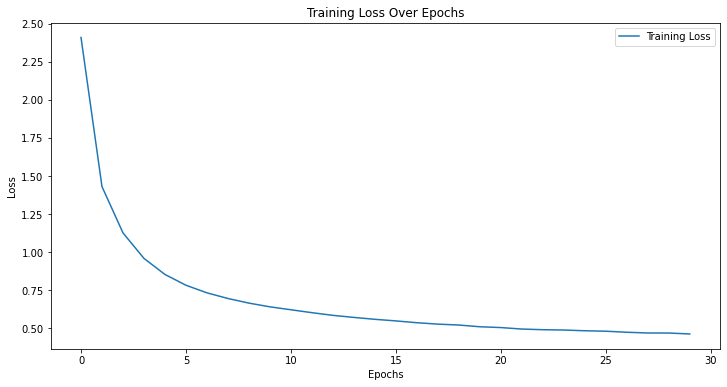

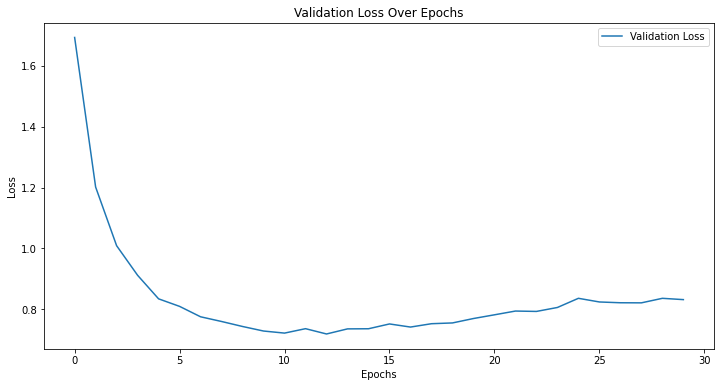

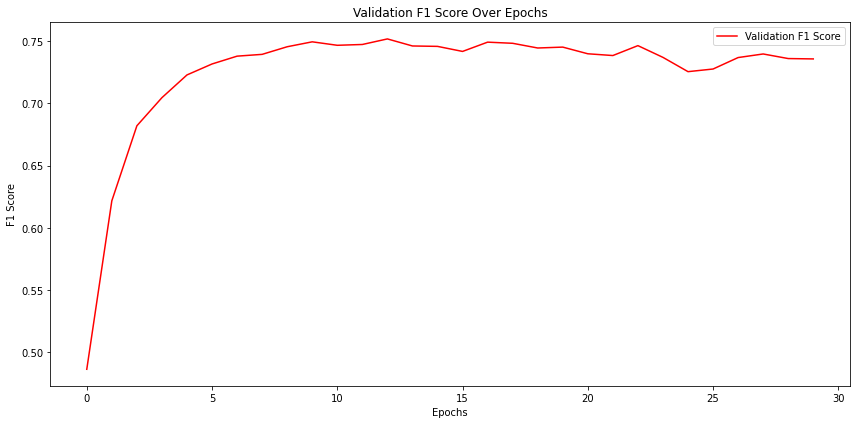

In [11]:
plt.figure(figsize=(12, 6))

plt.plot(loss_values_train, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure(figsize=(12, 6))

plt.plot(loss_values_val, label='Validation Loss')
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure(figsize=(12, 6))
plt.plot(f1_values, label='Validation F1 Score', color='red')
plt.title('Validation F1 Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader, TensorDataset

mlp_model.load_state_dict(best_model_state)
mlp_model.to(device)
mlp_model.eval()

test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.long).to(device))
test_loader = DataLoader(test_data, batch_size=8)

test_preds, test_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = mlp_model(inputs)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_pred_labels = encoder.inverse_transform(test_preds)
test_true_labels = encoder.inverse_transform(test_labels)

print("Classification Report on Test Set (Using Loaded Model):")
print(classification_report(test_true_labels, test_pred_labels))
report = classification_report(test_true_labels, test_pred_labels, output_dict=True)
macro_avg_f1 = report['macro avg']['f1-score']
weighted_avg_f1 = report['weighted avg']['f1-score']
print(f"Macro Average F1 Score: {macro_avg_f1}")
print(f"Weighted Average F1 Score: {weighted_avg_f1}")

Classification Report on Test Set (Using Loaded Model):
                                precision    recall  f1-score   support

          Allergy / Immunology       0.91      1.00      0.95       227
                       Autopsy       0.99      1.00      1.00       221
                    Bariatrics       0.89      0.93      0.91       230
    Cardiovascular / Pulmonary       0.52      0.49      0.50       204
                  Chiropractic       0.74      0.92      0.82       210
    Consult - History and Phy.       0.19      0.09      0.12       229
    Cosmetic / Plastic Surgery       0.83      0.83      0.83       208
                     Dentistry       0.92      0.93      0.92       229
                   Dermatology       0.87      0.94      0.90       213
          Diets and Nutritions       0.91      1.00      0.95       209
             Discharge Summary       0.61      0.50      0.55       214
          ENT - Otolaryngology       0.76      0.79      0.77       204
       

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

print(classification_report(test_true_labels, test_pred_labels))
report = classification_report(test_true_labels, test_pred_labels, output_dict=True)

cm = confusion_matrix(test_true_labels, test_pred_labels)

                                precision    recall  f1-score   support

          Allergy / Immunology       0.91      1.00      0.95       227
                       Autopsy       0.99      1.00      1.00       221
                    Bariatrics       0.89      0.93      0.91       230
    Cardiovascular / Pulmonary       0.52      0.49      0.50       204
                  Chiropractic       0.74      0.92      0.82       210
    Consult - History and Phy.       0.19      0.09      0.12       229
    Cosmetic / Plastic Surgery       0.83      0.83      0.83       208
                     Dentistry       0.92      0.93      0.92       229
                   Dermatology       0.87      0.94      0.90       213
          Diets and Nutritions       0.91      1.00      0.95       209
             Discharge Summary       0.61      0.50      0.55       214
          ENT - Otolaryngology       0.76      0.79      0.77       204
        Emergency Room Reports       0.63      0.64      0.63  

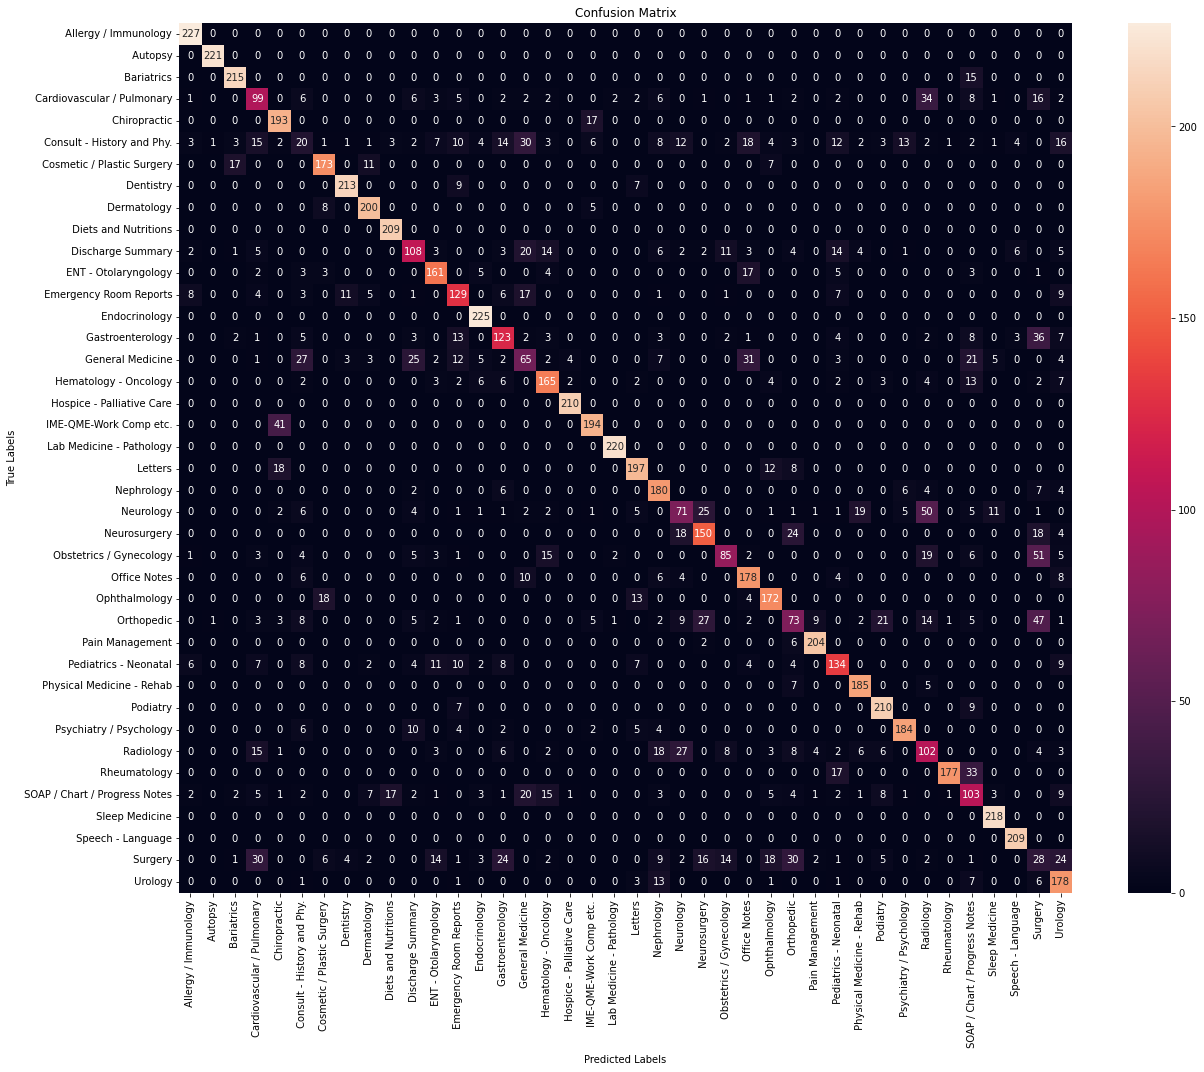

In [14]:
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=np.unique(test_true_labels), yticklabels=np.unique(test_true_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

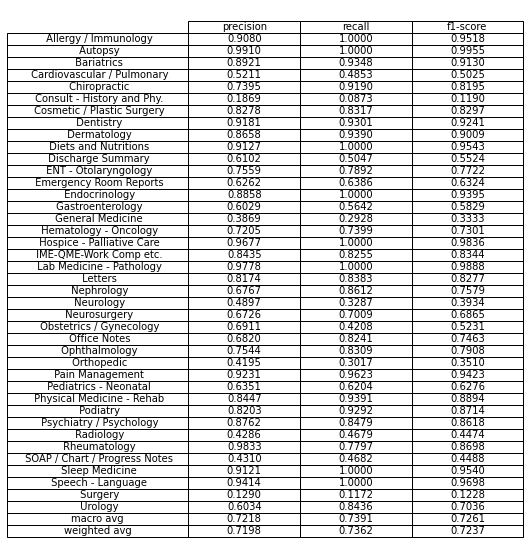

In [15]:
fig, ax = plt.subplots(figsize=(6, 10))
ax.axis('tight')
ax.axis('off')
formatted_cell_text = [
    [f"{value:.4f}" if isinstance(value, float) else f"{value}" for value in list(report[cls].values())[:-1]]
    for cls in report if cls != 'accuracy'
]

the_table = ax.table(
    cellText=formatted_cell_text,
    colLabels=['precision', 'recall', 'f1-score', 'support'],
    rowLabels=[cls for cls in report if cls != 'accuracy'],
    cellLoc='center', 
    rowLoc='center', 
    loc='center'
)

plt.show()
